# CSV data

This notebook shows how to:


1.   Train a NextStep-RNN on multiple time steps
2.   Evaluate the MAE with boxplots



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

In [2]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


In [ ]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

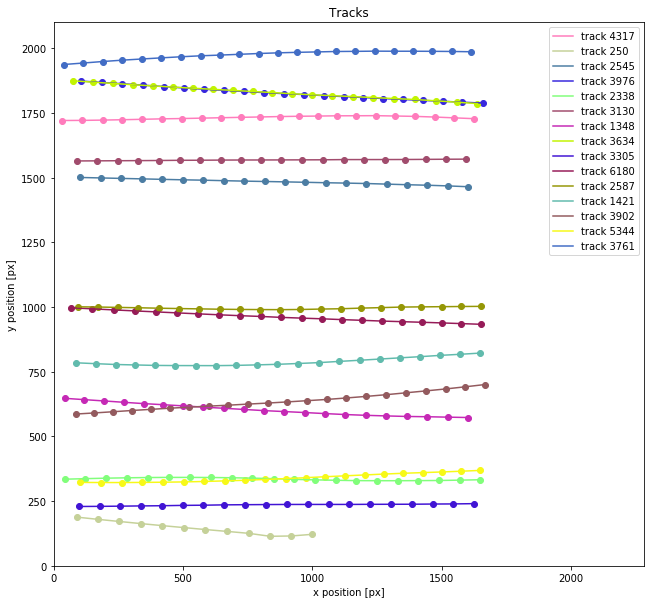

In [3]:
num_time_steps = 35
nan_value = 0
batch_size = 128


csv_data_set = data.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                               timesteps=num_time_steps, nan_value=nan_value)

# get tf.Dataset for sequential training
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [18]:
def get_median():
    maes = np.array([])

    mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
    normalization_factor = csv_data_set.belt_width

    for input_batch, target_batch in dataset_test:
        # reset state
        hidden = rnn_model.reset_states()

        batch_predictions = rnn_model(input_batch)

        # Calculate the mask
        mask = K.all(K.equal(target_batch, mask_value), axis=-1)
        mask = 1 - K.cast(mask, tf.float64)
        mask = K.cast(mask, tf.float64)

        target_batch_unnormalized = target_batch * normalization_factor
        pred_batch_unnormalized = batch_predictions * normalization_factor

        batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask

        num_time_steps_per_track = tf.reduce_sum(mask, axis=-1)

        batch_loss_per_track = tf.reduce_sum(batch_loss, axis=-1) / num_time_steps_per_track

        maes = np.concatenate((maes, batch_loss_per_track.numpy().reshape([-1])))

    return np.median(maes)

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (128, 35, 2)              0         
_________________________________________________________________
rnn-0 (LSTM)                 (128, 35, 1024)           4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (128, 35, 16)             66624     
_________________________________________________________________
dense_5 (Dense)              (128, 35, 2)              34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________
None
0/1000: 	 loss=0.008454028921454599
1/1000: 	 loss=0.0052467453119880905
2/1000: 	 loss=0.003871843435704157
3/1000: 	 loss=0.0022488342526784926
4/1000: 	 loss=0.0011965035105700938
5/1000: 	 loss=0.0006484650352859463
6/1000: 	 loss=0.

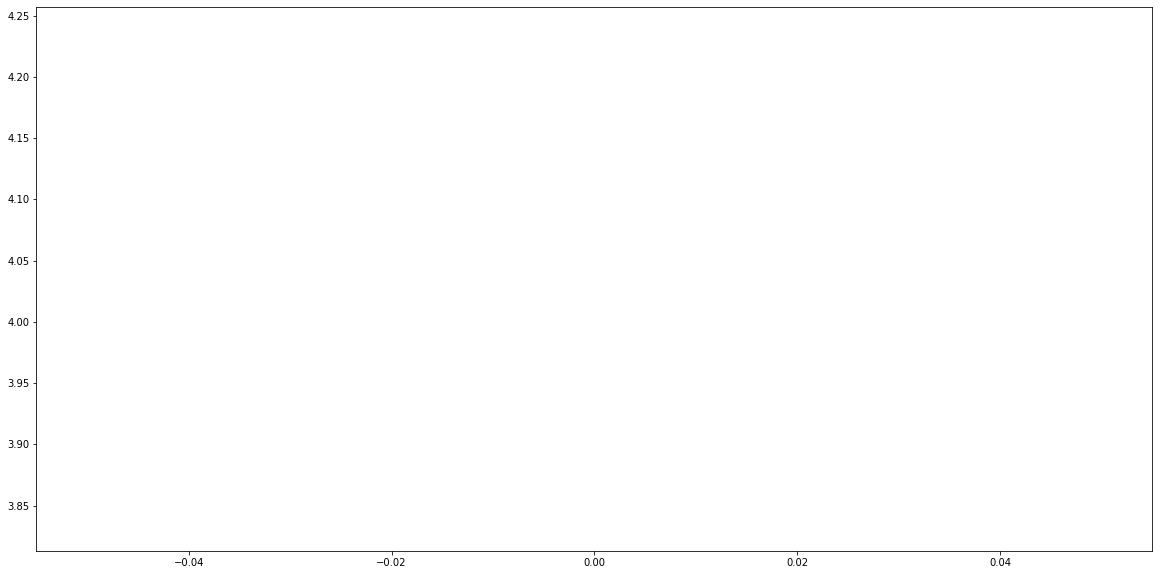

49/1000: 	 loss=4.131912728162285e-05
50/1000: 	 loss=4.352685187964778e-05
51/1000: 	 loss=2.5560564433574856e-05
52/1000: 	 loss=2.8992872856225035e-05
53/1000: 	 loss=1.974665833789302e-05
54/1000: 	 loss=1.9764655608802015e-05
55/1000: 	 loss=2.7572092535776865e-05
56/1000: 	 loss=2.625842617725373e-05
57/1000: 	 loss=1.2978349765031455e-05
58/1000: 	 loss=2.0380617532236492e-05
59/1000: 	 loss=1.2473260664868455e-05
60/1000: 	 loss=3.114475258874764e-05
61/1000: 	 loss=1.9720367330061196e-05
62/1000: 	 loss=1.6408497173841307e-05
63/1000: 	 loss=2.0262968207813216e-05
64/1000: 	 loss=1.248565438322824e-05
65/1000: 	 loss=1.551161195870979e-05
66/1000: 	 loss=9.586825520815944e-06
67/1000: 	 loss=1.806791835623078e-05
68/1000: 	 loss=1.4849937198153283e-05
69/1000: 	 loss=6.986104594301285e-06
70/1000: 	 loss=1.5679275131552168e-05
71/1000: 	 loss=1.4091444013606962e-05
72/1000: 	 loss=1.952754170306715e-05
73/1000: 	 loss=1.3682157300114415e-05
74/1000: 	 loss=8.496808676167328e-0

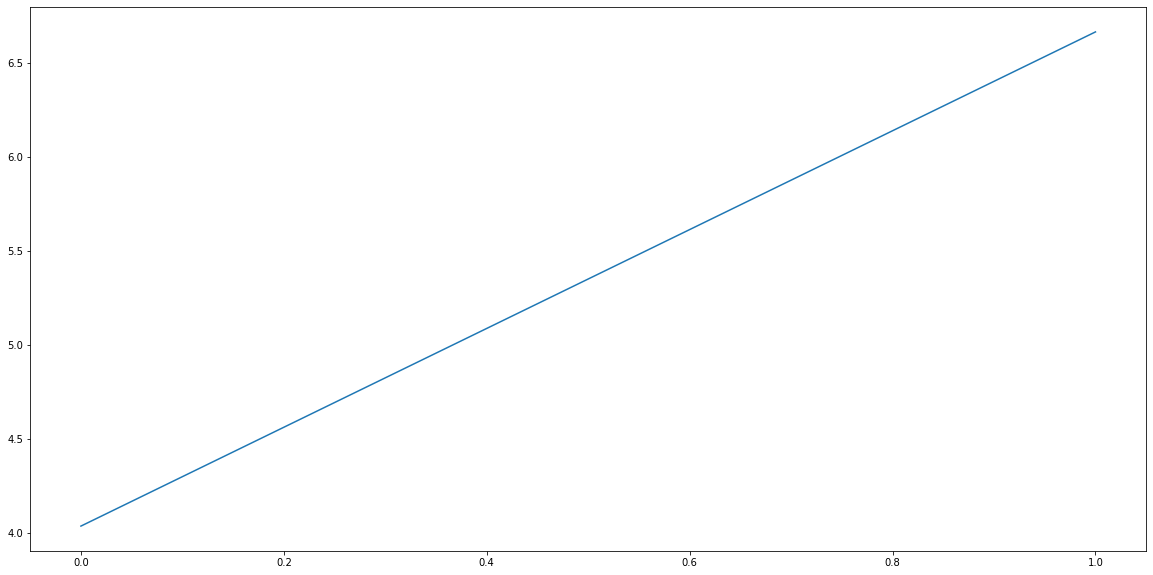

99/1000: 	 loss=1.8556877067196878e-05
100/1000: 	 loss=1.0610355368995053e-05
101/1000: 	 loss=4.826120675924107e-06
102/1000: 	 loss=7.473688890680953e-06
103/1000: 	 loss=6.665876095962696e-06
104/1000: 	 loss=6.04562301254642e-06
105/1000: 	 loss=5.9978087474170215e-06
106/1000: 	 loss=8.222008795646725e-06
107/1000: 	 loss=5.699312064483425e-06
108/1000: 	 loss=5.593553959135315e-06
109/1000: 	 loss=6.635511392266087e-06
110/1000: 	 loss=3.7839400415237207e-06
111/1000: 	 loss=1.2165282515597254e-05
112/1000: 	 loss=1.1222892676607283e-05
113/1000: 	 loss=4.7857502158820335e-06
114/1000: 	 loss=4.086300786321205e-06
115/1000: 	 loss=8.228811888240319e-06
116/1000: 	 loss=5.11562111178335e-06
117/1000: 	 loss=1.6590357225049846e-05
118/1000: 	 loss=4.574224494084121e-06
119/1000: 	 loss=1.3362631128087976e-05
120/1000: 	 loss=1.4877383858931005e-05
121/1000: 	 loss=1.0065911213523823e-05
122/1000: 	 loss=8.12052097405266e-06
123/1000: 	 loss=3.423500863002042e-06
124/1000: 	 loss=6

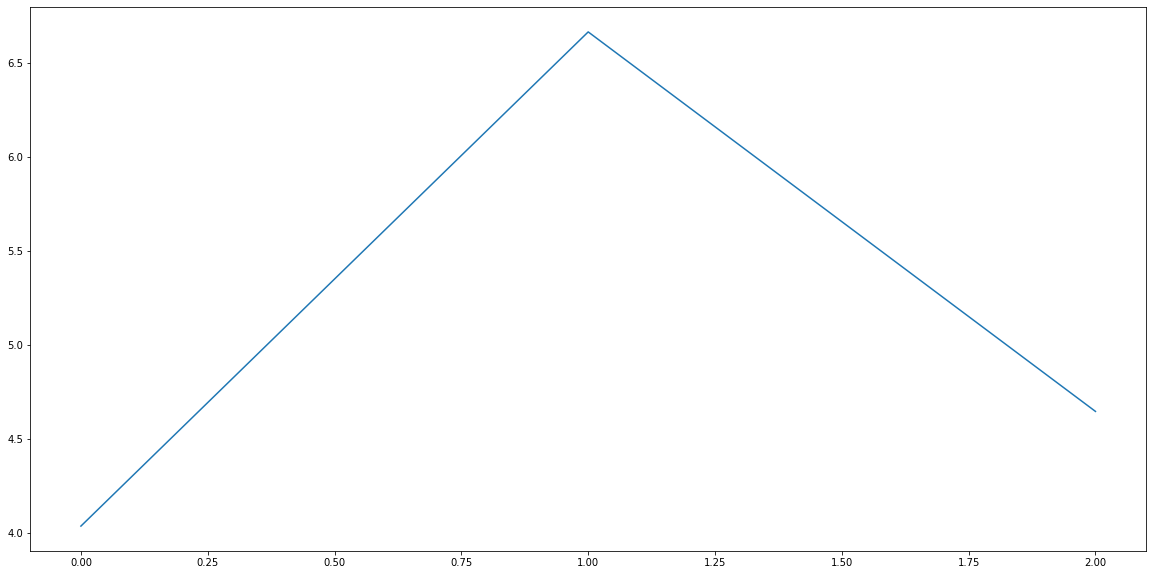

149/1000: 	 loss=5.602509345886466e-06
150/1000: 	 loss=4.1698995832911375e-06
151/1000: 	 loss=3.809769578636757e-06
152/1000: 	 loss=7.130776419983863e-06
153/1000: 	 loss=5.60453999534896e-06
154/1000: 	 loss=5.38825049654135e-05
155/1000: 	 loss=7.335145530084604e-06
156/1000: 	 loss=7.385081348463046e-06
157/1000: 	 loss=4.83217760543366e-06
158/1000: 	 loss=8.888800108900135e-06
159/1000: 	 loss=5.801371426540582e-06
160/1000: 	 loss=4.685792552955546e-06
161/1000: 	 loss=2.0022805967858672e-06
162/1000: 	 loss=4.086208490237061e-06
163/1000: 	 loss=9.546364619149362e-06
164/1000: 	 loss=3.92686296896484e-06
165/1000: 	 loss=3.653846712107198e-06
166/1000: 	 loss=2.392560893885968e-06
167/1000: 	 loss=5.265833369698617e-06
168/1000: 	 loss=1.0879727727865428e-05
169/1000: 	 loss=5.068254301790681e-06
170/1000: 	 loss=6.03561892593695e-06
171/1000: 	 loss=2.0749264680869362e-05
172/1000: 	 loss=6.953054518567295e-06
173/1000: 	 loss=8.896530246160457e-06
174/1000: 	 loss=7.9278477

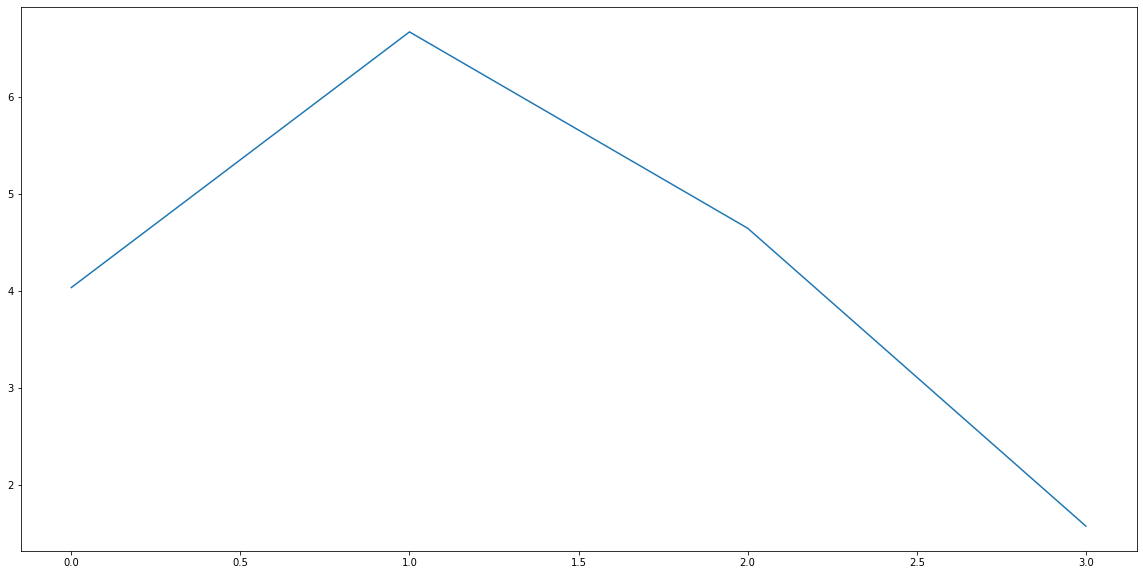

199/1000: 	 loss=1.3743435985162637e-06
200/1000: 	 loss=1.69380368602825e-06
201/1000: 	 loss=5.186044377787643e-06
202/1000: 	 loss=1.7612911443397998e-06
203/1000: 	 loss=2.6375974347181685e-06
204/1000: 	 loss=3.7736173514150674e-06
205/1000: 	 loss=3.891408334286934e-06
206/1000: 	 loss=3.6987827318157022e-06
207/1000: 	 loss=1.375485800257698e-06
208/1000: 	 loss=2.207519364234729e-06
209/1000: 	 loss=2.5250986670778645e-06
210/1000: 	 loss=2.257491762434352e-06
211/1000: 	 loss=4.300985883486242e-06
212/1000: 	 loss=2.4033302343643043e-06
213/1000: 	 loss=5.484973605326725e-06
214/1000: 	 loss=2.2181095590393756e-06
215/1000: 	 loss=2.3729034893337903e-06
216/1000: 	 loss=6.2895073648429e-06
217/1000: 	 loss=7.416731538882726e-06
218/1000: 	 loss=2.5439340165844706e-06
219/1000: 	 loss=3.1978272589326147e-06
220/1000: 	 loss=2.4321461042981572e-06
221/1000: 	 loss=9.641360500609967e-07
222/1000: 	 loss=3.29527327228394e-06
223/1000: 	 loss=1.3085566956914942e-06
224/1000: 	 loss

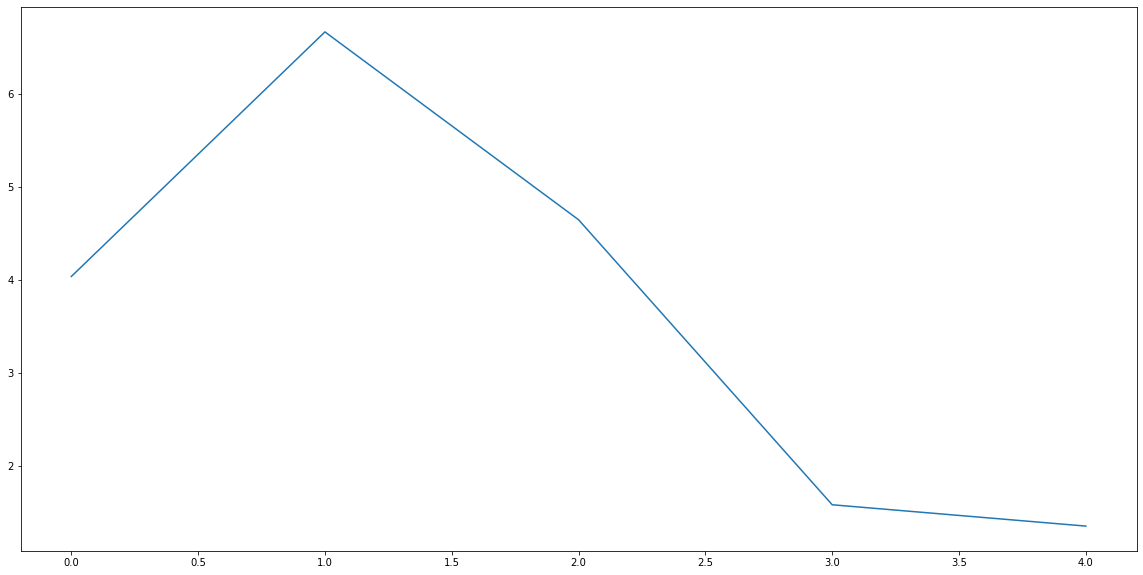

249/1000: 	 loss=3.7450371832534945e-06
250/1000: 	 loss=3.4635883701642424e-06
251/1000: 	 loss=1.2159008760872072e-06
252/1000: 	 loss=5.03752918005496e-06
253/1000: 	 loss=1.1482916040639528e-06
254/1000: 	 loss=1.1366203215143372e-06
255/1000: 	 loss=2.1506036565656193e-06
256/1000: 	 loss=1.1440530448840423e-06
257/1000: 	 loss=5.3281863588219065e-06
258/1000: 	 loss=1.0969849153102837e-06
259/1000: 	 loss=1.1165095245842194e-06
260/1000: 	 loss=9.745265567442962e-07
261/1000: 	 loss=6.316311485174413e-06
262/1000: 	 loss=9.956419199803063e-07
263/1000: 	 loss=5.694021968500204e-06
264/1000: 	 loss=2.0660986947937877e-06
265/1000: 	 loss=2.148712348170678e-06
266/1000: 	 loss=4.608419492399047e-06
267/1000: 	 loss=1.0535349200720857e-06
268/1000: 	 loss=9.239207607678542e-07
269/1000: 	 loss=3.439188308509603e-06
270/1000: 	 loss=9.915459984686874e-07
271/1000: 	 loss=1.360618569561368e-06
272/1000: 	 loss=1.0321146923203192e-06
273/1000: 	 loss=3.8506327521302375e-06
274/1000: 	 

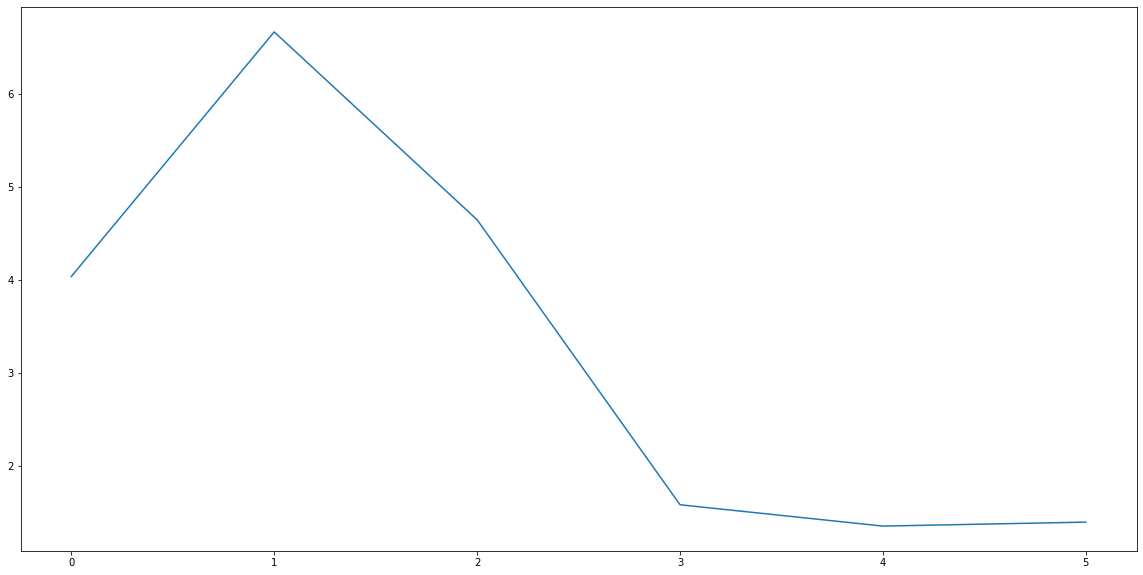

299/1000: 	 loss=2.086640872624348e-06
300/1000: 	 loss=2.479145065295093e-06
301/1000: 	 loss=2.1987888918089525e-06
302/1000: 	 loss=4.9265808519207855e-06
303/1000: 	 loss=2.7100722412071225e-06
304/1000: 	 loss=3.0843854705146903e-06
305/1000: 	 loss=5.133224169467388e-06
306/1000: 	 loss=2.854845236088879e-06
307/1000: 	 loss=9.7632914727658e-07
308/1000: 	 loss=1.1270805163377409e-06
309/1000: 	 loss=2.470600457382889e-06
310/1000: 	 loss=4.9025880302224125e-06
311/1000: 	 loss=1.026047159754563e-06
312/1000: 	 loss=1.3072577343189549e-06
313/1000: 	 loss=2.0587413541709124e-06
314/1000: 	 loss=2.3423783471669118e-06
315/1000: 	 loss=4.387219949831219e-06
316/1000: 	 loss=7.660660012294815e-06
317/1000: 	 loss=3.3221228316509256e-06
318/1000: 	 loss=2.6389491162846536e-06
319/1000: 	 loss=8.790687671981401e-07
320/1000: 	 loss=3.503480821711141e-06
321/1000: 	 loss=1.0437775686212366e-06
322/1000: 	 loss=3.754301498099375e-06
323/1000: 	 loss=2.089922423312823e-06
324/1000: 	 los

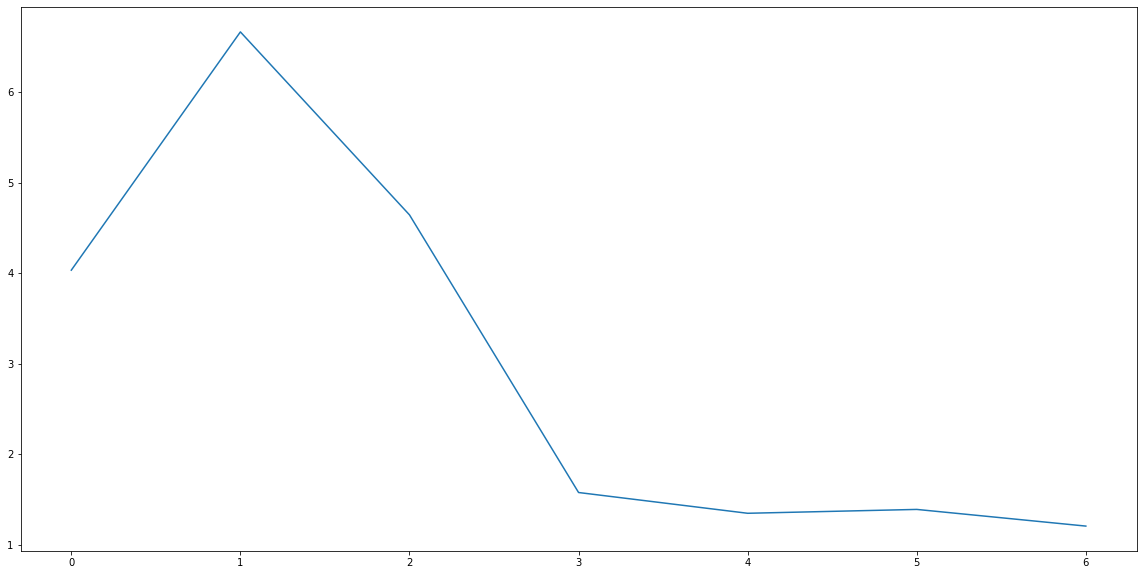

349/1000: 	 loss=9.8791427190452e-07
350/1000: 	 loss=5.077615777889561e-06
351/1000: 	 loss=2.0831384479183877e-06
352/1000: 	 loss=4.274738834000237e-06
353/1000: 	 loss=2.183131221522622e-06
354/1000: 	 loss=8.642798328710361e-07
355/1000: 	 loss=8.454932655399896e-07
356/1000: 	 loss=3.3760198678099783e-06
357/1000: 	 loss=1.8900837005890158e-06
358/1000: 	 loss=3.417039780797381e-06
359/1000: 	 loss=3.0863737420970895e-06
360/1000: 	 loss=1.0006731170792865e-06
361/1000: 	 loss=9.30547751416029e-07
362/1000: 	 loss=5.579969954157758e-06
363/1000: 	 loss=2.030134491052647e-06
364/1000: 	 loss=3.777671358003525e-06
365/1000: 	 loss=2.2852979907346834e-06
366/1000: 	 loss=3.205674058431798e-06
367/1000: 	 loss=9.99662821471425e-07
368/1000: 	 loss=3.905678343907606e-06
369/1000: 	 loss=9.253827036215621e-07
370/1000: 	 loss=5.689694835284175e-06
371/1000: 	 loss=3.2605584748724042e-06
372/1000: 	 loss=5.809897928340358e-06
373/1000: 	 loss=3.1896965401316686e-06
374/1000: 	 loss=3.67

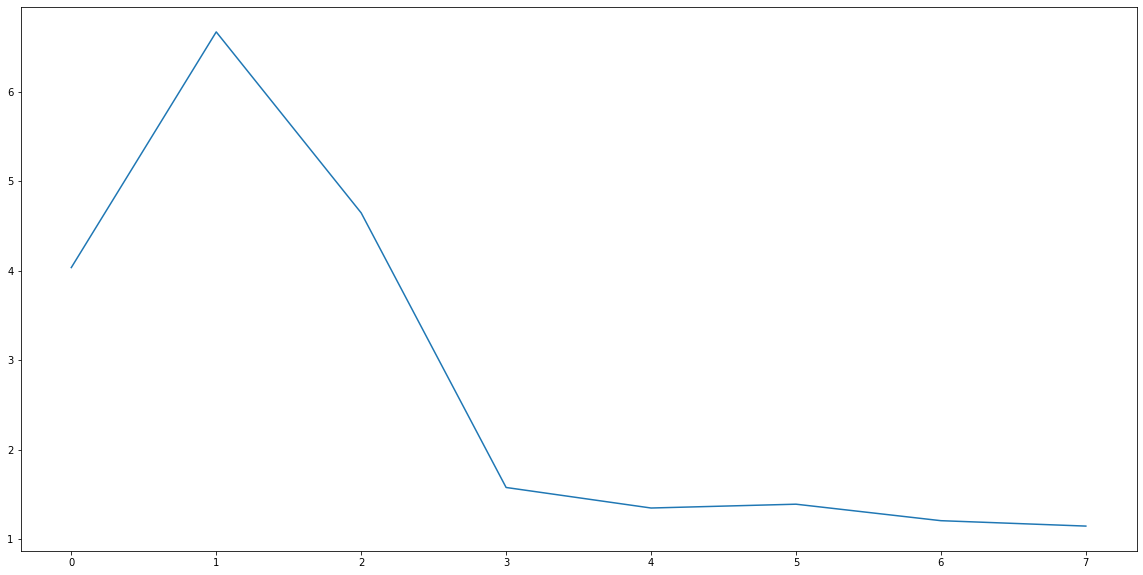

399/1000: 	 loss=9.4630341013338e-07
400/1000: 	 loss=6.5585346133149015e-06
401/1000: 	 loss=1.7171294251050661e-06
402/1000: 	 loss=1.941397071998115e-06
403/1000: 	 loss=2.934367082345233e-06
404/1000: 	 loss=2.0338722934006274e-06
405/1000: 	 loss=7.205807305660083e-07
406/1000: 	 loss=8.870014419184165e-07
407/1000: 	 loss=7.344323339443033e-06
408/1000: 	 loss=1.9511928063394082e-06
409/1000: 	 loss=2.063521003232783e-06
410/1000: 	 loss=3.961774179375656e-06
411/1000: 	 loss=2.047465472310052e-06
412/1000: 	 loss=5.437799530607747e-06
413/1000: 	 loss=1.9748814907160905e-06
414/1000: 	 loss=2.8209301740807683e-06
415/1000: 	 loss=3.39976920497159e-06
416/1000: 	 loss=3.2232334902066558e-06
417/1000: 	 loss=4.493296604921232e-06
418/1000: 	 loss=4.052245139656098e-06
419/1000: 	 loss=4.153132632962501e-06
420/1000: 	 loss=4.33402794208065e-06
421/1000: 	 loss=8.346881545117975e-07
422/1000: 	 loss=6.242755491111668e-06
423/1000: 	 loss=3.471447343308701e-06
424/1000: 	 loss=1.889

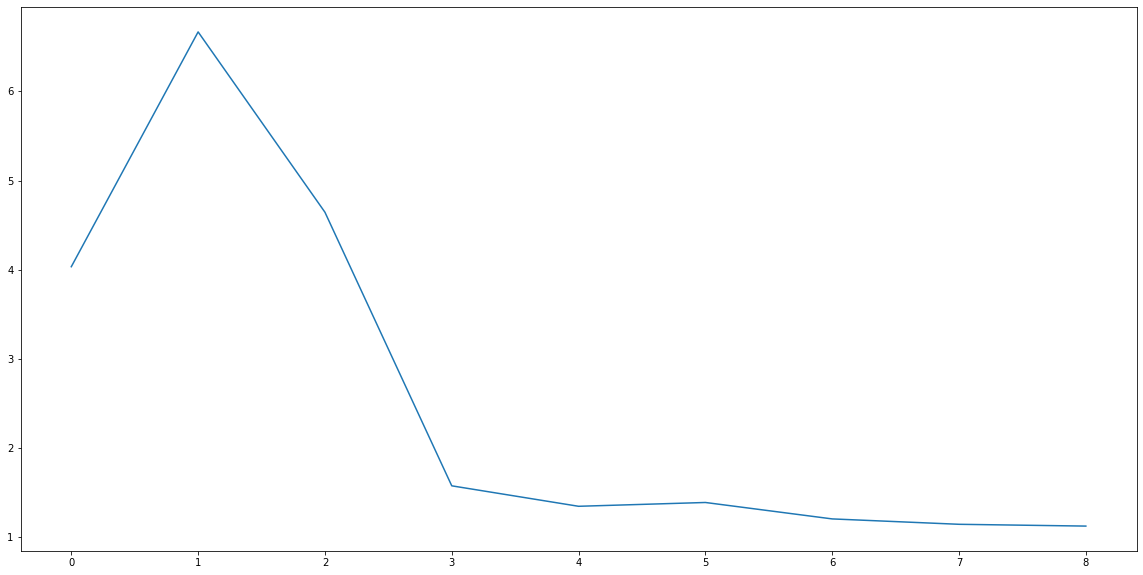

449/1000: 	 loss=2.9463644351929453e-06
450/1000: 	 loss=7.597282823981569e-07
451/1000: 	 loss=4.287212382156321e-06
452/1000: 	 loss=8.689423520028653e-07
453/1000: 	 loss=1.972280609848539e-06
454/1000: 	 loss=2.0711944108484636e-06
455/1000: 	 loss=4.873368561798849e-06
456/1000: 	 loss=2.9124468725196823e-06
457/1000: 	 loss=2.5885044230317925e-06
458/1000: 	 loss=6.547415042895729e-07
459/1000: 	 loss=3.586378713680471e-06
460/1000: 	 loss=6.470841216208125e-06
461/1000: 	 loss=6.41588451210985e-06
462/1000: 	 loss=8.612024967218624e-07
463/1000: 	 loss=3.3200888729763804e-06
464/1000: 	 loss=9.807977233429089e-06
465/1000: 	 loss=5.295505860608658e-06
466/1000: 	 loss=3.6893175063025396e-06
467/1000: 	 loss=3.1558715265314916e-06
468/1000: 	 loss=1.950615782621549e-06
469/1000: 	 loss=4.632670282998629e-06
470/1000: 	 loss=2.0257383059802347e-06
471/1000: 	 loss=4.2620320145229974e-06
472/1000: 	 loss=3.388412948074474e-06
473/1000: 	 loss=7.292030622094918e-07
474/1000: 	 loss=

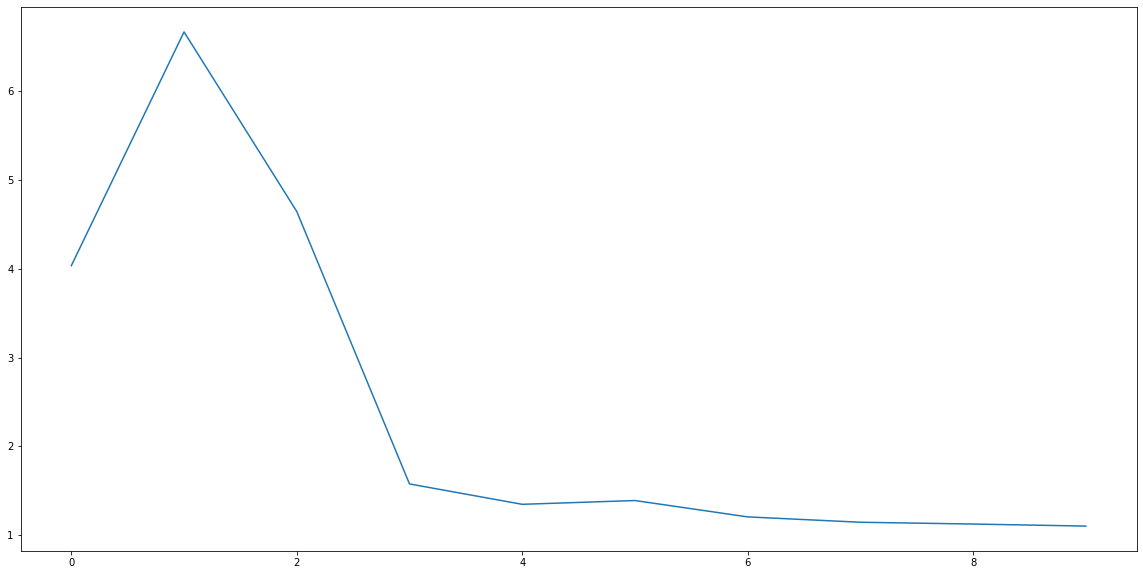

499/1000: 	 loss=4.071040232328143e-06
500/1000: 	 loss=7.931663585682881e-07
501/1000: 	 loss=1.7012395060106788e-06
502/1000: 	 loss=3.6237526723702828e-06
503/1000: 	 loss=3.0845276511611454e-06
504/1000: 	 loss=4.315864952181249e-06
505/1000: 	 loss=7.779242305446205e-07
506/1000: 	 loss=8.107083377031721e-07
507/1000: 	 loss=1.722602788970845e-06
508/1000: 	 loss=7.015032770390155e-07
509/1000: 	 loss=6.6771883382363375e-06
510/1000: 	 loss=7.573401331297621e-07
511/1000: 	 loss=9.276200173482024e-07
512/1000: 	 loss=1.795960834439497e-06
513/1000: 	 loss=2.126035298807836e-06
514/1000: 	 loss=7.0983019652472046e-06
515/1000: 	 loss=1.8069437039396537e-06
516/1000: 	 loss=7.376741483712245e-07
517/1000: 	 loss=7.556589316100202e-07
518/1000: 	 loss=2.5986108418347165e-06
519/1000: 	 loss=2.8667211605004983e-06
520/1000: 	 loss=5.171699908490228e-06
521/1000: 	 loss=4.4287387739639646e-06
522/1000: 	 loss=1.8599332896322778e-06
523/1000: 	 loss=7.953076664016617e-07
524/1000: 	 los

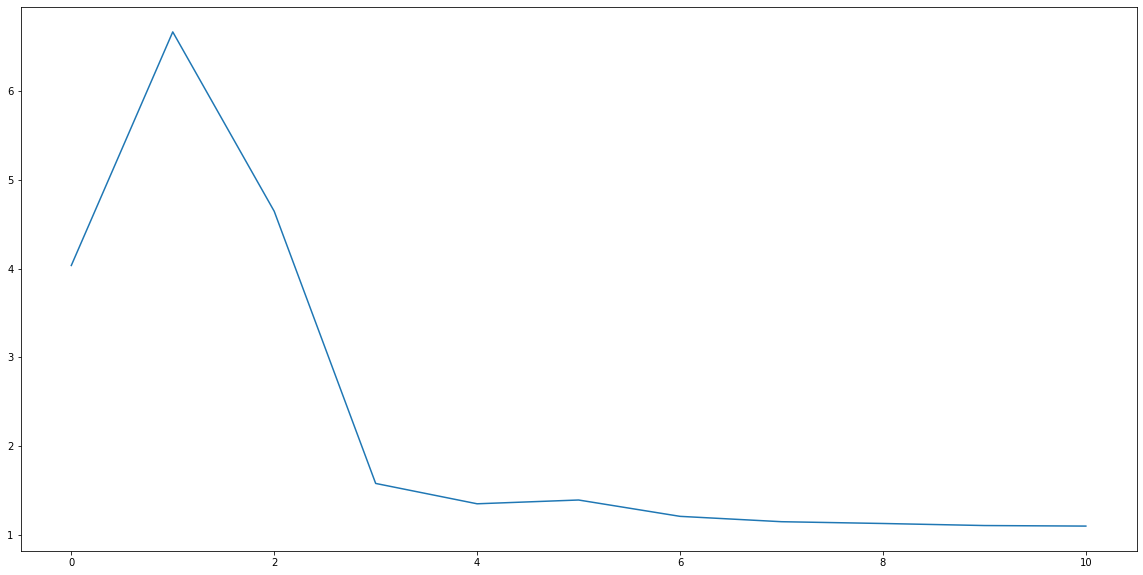

549/1000: 	 loss=2.9919253685367845e-06
550/1000: 	 loss=3.593568209164351e-06
551/1000: 	 loss=7.623617730474155e-07
552/1000: 	 loss=1.6875646484435234e-06
553/1000: 	 loss=2.7729718745298566e-06
554/1000: 	 loss=5.073822099045662e-06
555/1000: 	 loss=4.99182027931747e-06
556/1000: 	 loss=7.726200668890303e-07
557/1000: 	 loss=2.8575948800199748e-06
558/1000: 	 loss=8.597780413504977e-07
559/1000: 	 loss=6.465523873042878e-07
560/1000: 	 loss=2.8248578563814624e-06
561/1000: 	 loss=1.9789872089011272e-06
562/1000: 	 loss=8.442428248878838e-06
563/1000: 	 loss=7.805447041884353e-07
564/1000: 	 loss=8.434298570539307e-07
565/1000: 	 loss=6.618662434274525e-07
566/1000: 	 loss=3.3444270077257755e-06
567/1000: 	 loss=1.8061132709952464e-06
568/1000: 	 loss=5.943589285021003e-07
569/1000: 	 loss=7.387888049013935e-07
570/1000: 	 loss=1.8644146768768063e-06
571/1000: 	 loss=3.2337453949213404e-06
572/1000: 	 loss=3.1084696867196903e-06
573/1000: 	 loss=4.116820715307075e-06
574/1000: 	 los

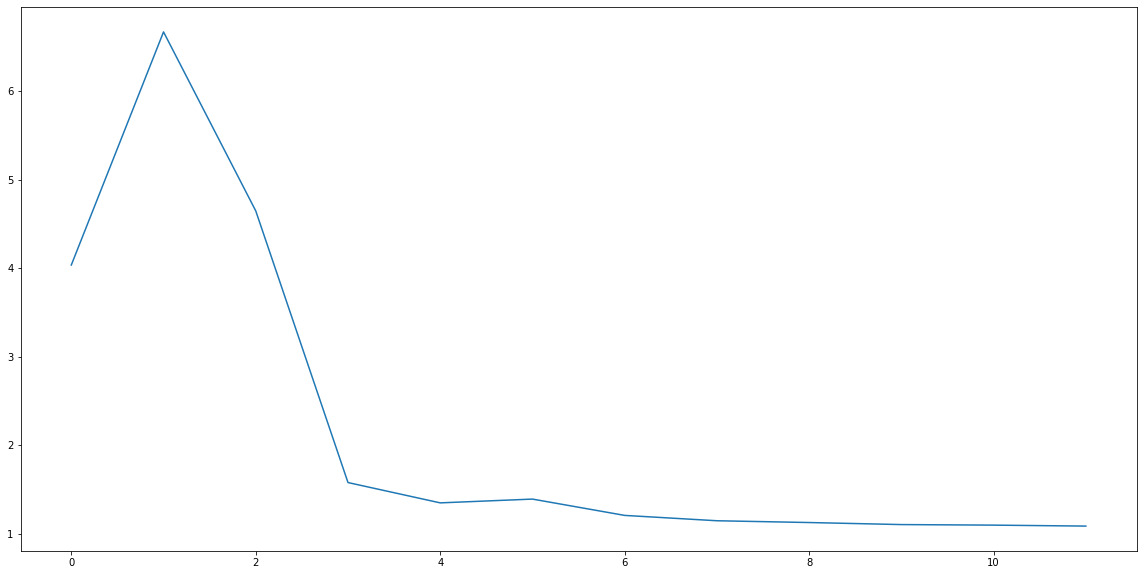

599/1000: 	 loss=2.8644626816055408e-06
600/1000: 	 loss=2.548553525663662e-06
601/1000: 	 loss=1.6989720667623634e-06
602/1000: 	 loss=7.3515768353128025e-06
603/1000: 	 loss=8.437466158400023e-07
604/1000: 	 loss=1.7195829525524434e-06
605/1000: 	 loss=4.229576905640348e-06
606/1000: 	 loss=3.380135801366321e-06
607/1000: 	 loss=5.323732972872672e-06
608/1000: 	 loss=1.712426137011605e-06
609/1000: 	 loss=1.669612104518154e-06
610/1000: 	 loss=2.983753815806827e-06
611/1000: 	 loss=3.0900978384424344e-06
612/1000: 	 loss=2.7818286295610164e-06
613/1000: 	 loss=3.1730607013150812e-06
614/1000: 	 loss=7.972053460654787e-07
615/1000: 	 loss=3.0099365408146443e-06
616/1000: 	 loss=2.4829385062363697e-06
617/1000: 	 loss=3.0692713552854005e-06
618/1000: 	 loss=8.36313878233456e-07
619/1000: 	 loss=7.426026790115373e-07
620/1000: 	 loss=1.743534499756715e-06
621/1000: 	 loss=7.870356741297689e-06
622/1000: 	 loss=6.686834301836629e-07
623/1000: 	 loss=7.103006366310768e-07
624/1000: 	 loss

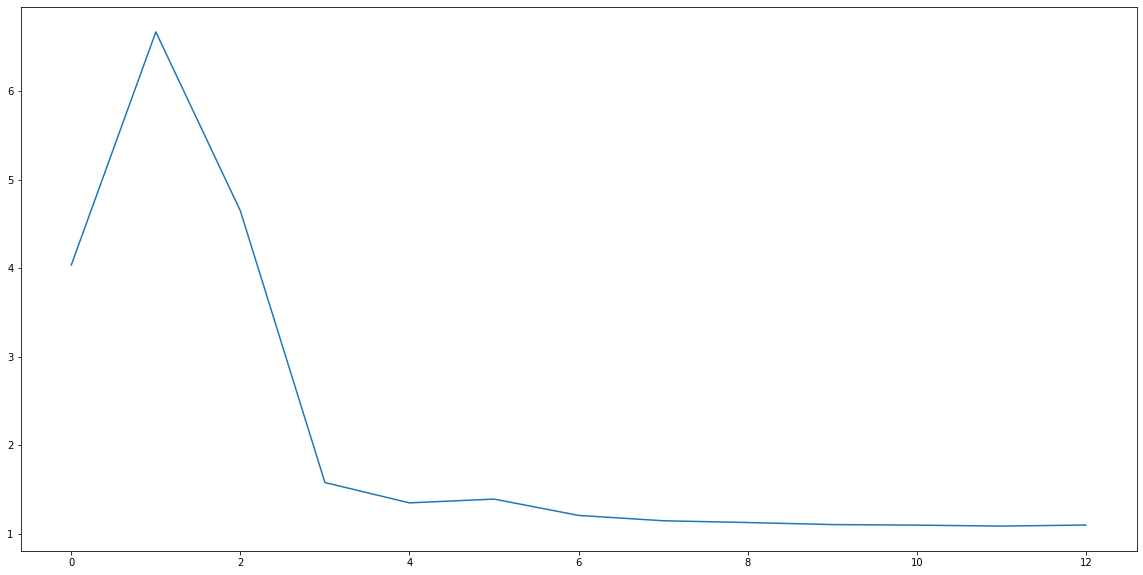

649/1000: 	 loss=1.6567326344488959e-06
650/1000: 	 loss=1.5273516604439295e-06
651/1000: 	 loss=2.0382035737874746e-06
652/1000: 	 loss=6.712023720484896e-07
653/1000: 	 loss=4.2082862814343616e-06
654/1000: 	 loss=3.4496466278716344e-06
655/1000: 	 loss=1.8779466630771639e-06
656/1000: 	 loss=4.188001635655994e-06
657/1000: 	 loss=8.866652455511267e-07
658/1000: 	 loss=3.1214178039204806e-06
659/1000: 	 loss=3.0634465276150896e-06
660/1000: 	 loss=3.1434705764018274e-06
661/1000: 	 loss=5.261146235610993e-06
662/1000: 	 loss=1.7146024797066506e-06
663/1000: 	 loss=6.574897227682114e-07
664/1000: 	 loss=7.13444570022971e-07
665/1000: 	 loss=2.0138756082932233e-06
666/1000: 	 loss=2.0403950643330867e-06
667/1000: 	 loss=7.516190632351805e-07
668/1000: 	 loss=8.948719310955793e-07
669/1000: 	 loss=1.0156619957725475e-05
670/1000: 	 loss=2.5725877928897017e-06
671/1000: 	 loss=6.10184077938902e-06
672/1000: 	 loss=1.9534370463689584e-06
673/1000: 	 loss=7.136187806672013e-07
674/1000: 	 

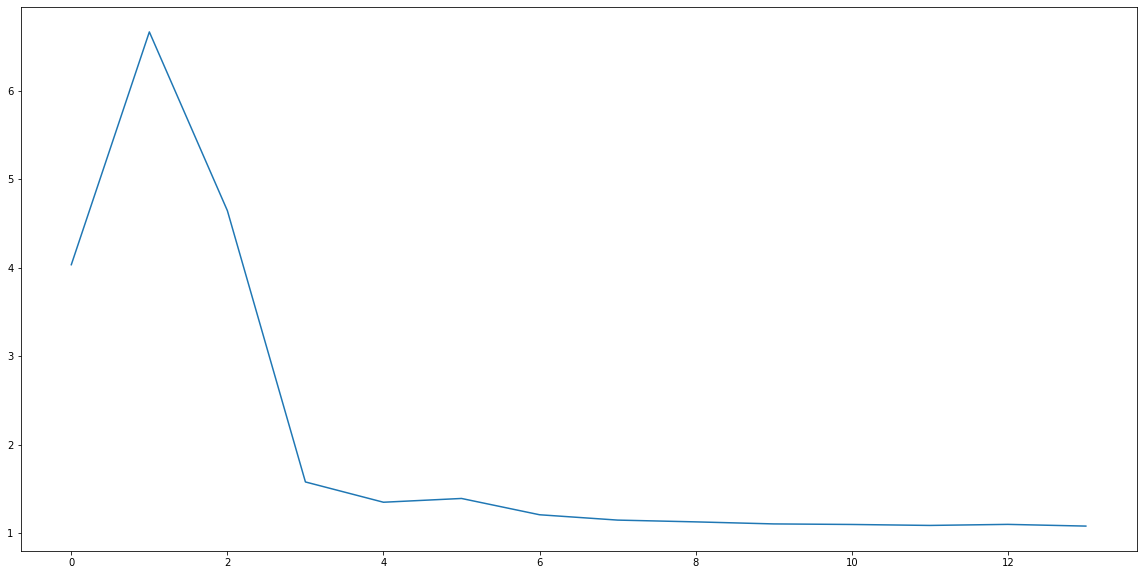

699/1000: 	 loss=1.7883519880547465e-06
700/1000: 	 loss=2.7574868560773104e-06
701/1000: 	 loss=9.760382797932092e-07
702/1000: 	 loss=8.763639311556062e-07
703/1000: 	 loss=4.922495205645403e-06
704/1000: 	 loss=7.586462601549649e-06
705/1000: 	 loss=6.310935586879426e-06
706/1000: 	 loss=7.330278135413929e-07
707/1000: 	 loss=4.444528386530546e-06
708/1000: 	 loss=3.121358847554859e-06
709/1000: 	 loss=2.872088879834324e-06
710/1000: 	 loss=7.042955758548378e-07
711/1000: 	 loss=4.803231028485606e-06
712/1000: 	 loss=1.204115350464942e-06
713/1000: 	 loss=1.911784496525114e-06
714/1000: 	 loss=9.710660774297995e-07
715/1000: 	 loss=1.8072586910886808e-06
716/1000: 	 loss=5.863631603973417e-06
717/1000: 	 loss=7.0136669272750946e-06
718/1000: 	 loss=7.976797589040324e-07
719/1000: 	 loss=6.929466490701181e-07
720/1000: 	 loss=3.2053570604470398e-06
721/1000: 	 loss=7.5398021687143194e-06
722/1000: 	 loss=5.12094029923927e-06
723/1000: 	 loss=1.8745713186711522e-06
724/1000: 	 loss=7.

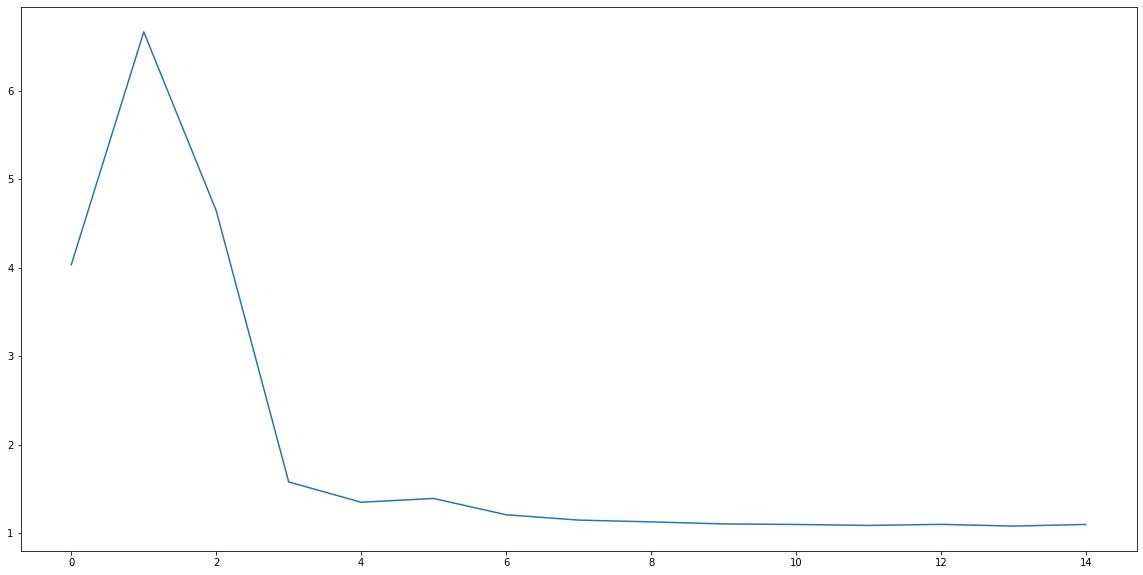

749/1000: 	 loss=4.14296123131191e-06
750/1000: 	 loss=2.902382328606608e-06
751/1000: 	 loss=4.758729086605586e-06
752/1000: 	 loss=8.652531909218872e-07
753/1000: 	 loss=2.808682024600101e-06
754/1000: 	 loss=3.494336347309182e-06
755/1000: 	 loss=8.320080504507637e-06
756/1000: 	 loss=2.0171257965971554e-06
757/1000: 	 loss=2.0259652969725866e-06
758/1000: 	 loss=2.7798438082878016e-06
759/1000: 	 loss=3.347184330388137e-06
760/1000: 	 loss=1.850011183838965e-06
761/1000: 	 loss=6.401430840953908e-06
762/1000: 	 loss=9.004171979543735e-07
763/1000: 	 loss=1.8108291548682142e-06
764/1000: 	 loss=6.806995753142727e-06
765/1000: 	 loss=4.388053616215252e-06
766/1000: 	 loss=3.172969946154038e-06
767/1000: 	 loss=5.723324427992617e-06
768/1000: 	 loss=7.185974323755954e-06
769/1000: 	 loss=1.8980413205769404e-06
770/1000: 	 loss=1.9731798855476854e-06
771/1000: 	 loss=7.428537345151881e-07
772/1000: 	 loss=3.4196524795990926e-06
773/1000: 	 loss=1.835501255728468e-06
774/1000: 	 loss=7.

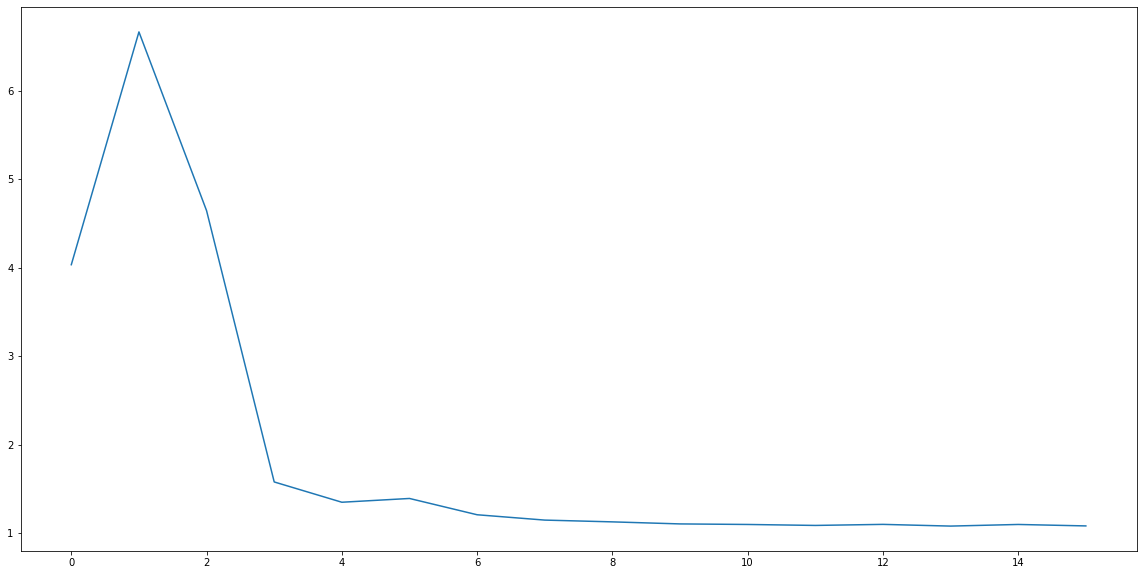

799/1000: 	 loss=1.779456330780713e-06
800/1000: 	 loss=2.2195072763694925e-06
801/1000: 	 loss=6.231969085845383e-07
802/1000: 	 loss=1.7780807700239997e-06
803/1000: 	 loss=4.836571247076968e-06
804/1000: 	 loss=1.7290920539670643e-06
805/1000: 	 loss=8.100360001716433e-07
806/1000: 	 loss=1.706322580848788e-06
807/1000: 	 loss=2.3083372980695554e-06
808/1000: 	 loss=3.1663702164873872e-06
809/1000: 	 loss=1.77222316712738e-06
810/1000: 	 loss=4.429435760959053e-06
811/1000: 	 loss=3.788651419051172e-06
812/1000: 	 loss=2.062133106973928e-06
813/1000: 	 loss=5.903045844841016e-06
814/1000: 	 loss=1.6929240826081445e-06
815/1000: 	 loss=3.2212156451842695e-06
816/1000: 	 loss=4.2876382014101395e-06
817/1000: 	 loss=4.0355793450443946e-06
818/1000: 	 loss=6.781156429869228e-07
819/1000: 	 loss=4.747112395653795e-06
820/1000: 	 loss=3.2036619146200265e-06
821/1000: 	 loss=2.725931443874034e-06
822/1000: 	 loss=8.541868227071175e-07
823/1000: 	 loss=6.689469203406347e-07
824/1000: 	 loss

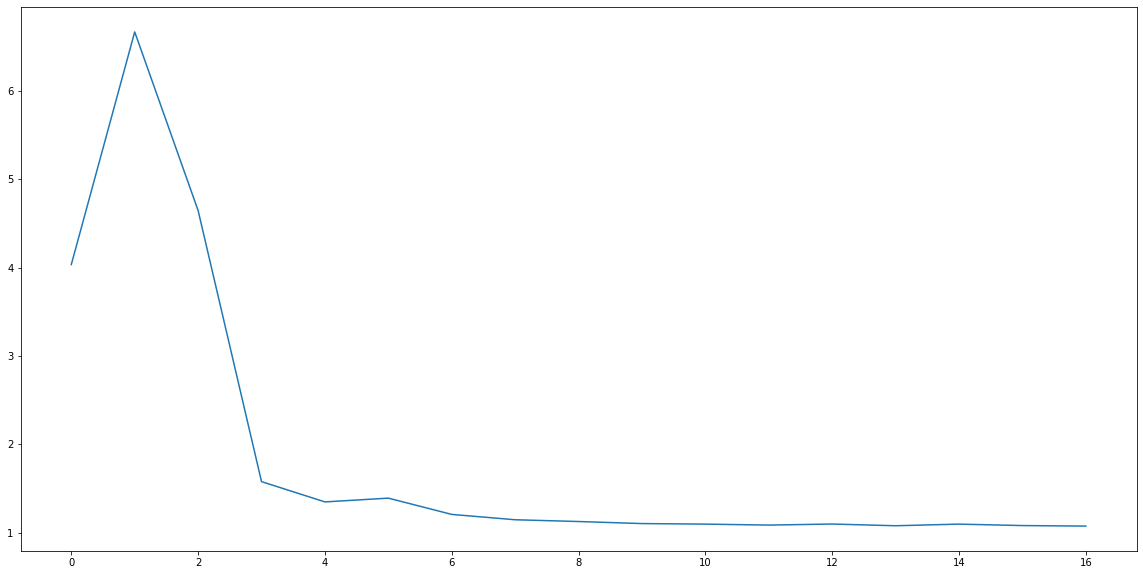

849/1000: 	 loss=1.8018679935366363e-06
850/1000: 	 loss=1.6808236941010377e-06
851/1000: 	 loss=8.272039393068257e-07
852/1000: 	 loss=8.660464070442342e-06
853/1000: 	 loss=4.490641536218515e-06
854/1000: 	 loss=8.866343073074793e-07
855/1000: 	 loss=6.541562425693199e-07
856/1000: 	 loss=5.309674238649288e-06
857/1000: 	 loss=6.678156485070984e-06
858/1000: 	 loss=1.7028258973434476e-06
859/1000: 	 loss=7.464572868112899e-07
860/1000: 	 loss=1.8862822957649456e-06
861/1000: 	 loss=7.013023192243673e-07
862/1000: 	 loss=6.982046580257073e-07
863/1000: 	 loss=7.1104211122166465e-06
864/1000: 	 loss=1.8716916706213995e-06
865/1000: 	 loss=1.9884614665886497e-06
866/1000: 	 loss=6.340244256774283e-07
867/1000: 	 loss=1.7782396412351227e-06
868/1000: 	 loss=4.161569293300961e-06
869/1000: 	 loss=3.270627815966119e-06
870/1000: 	 loss=1.6358857603062677e-06
871/1000: 	 loss=9.024532378097856e-06
872/1000: 	 loss=1.9487201000559615e-06
873/1000: 	 loss=7.073535502476353e-07
874/1000: 	 los

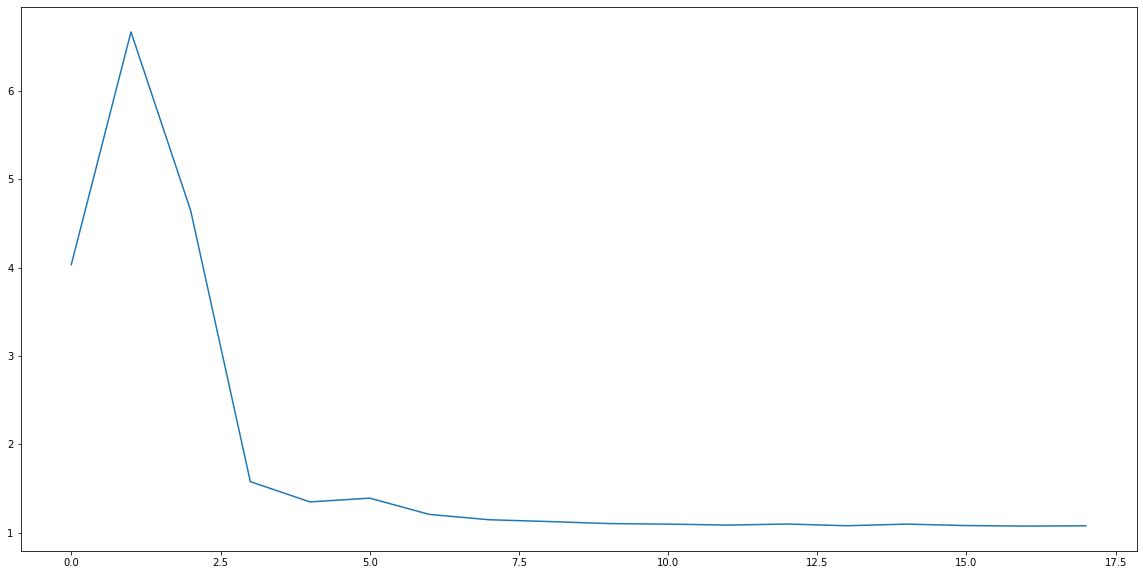

899/1000: 	 loss=1.6814596165122912e-06
900/1000: 	 loss=4.584515529869049e-06
901/1000: 	 loss=3.0772865621852723e-06
902/1000: 	 loss=5.675382275476432e-06
903/1000: 	 loss=5.622976437131288e-06
904/1000: 	 loss=1.9799731384764724e-06
905/1000: 	 loss=6.816858032773811e-07
906/1000: 	 loss=5.160429299401711e-06
907/1000: 	 loss=2.1784772994770772e-06
908/1000: 	 loss=4.631454325491914e-06
909/1000: 	 loss=8.73161837389788e-07
910/1000: 	 loss=1.7960894103390793e-06
911/1000: 	 loss=1.734282312395158e-06
912/1000: 	 loss=1.994577383777602e-06
913/1000: 	 loss=3.760303640639495e-06
914/1000: 	 loss=2.3207167966804944e-06
915/1000: 	 loss=2.1058373890681754e-06
916/1000: 	 loss=2.7982091569042864e-06
917/1000: 	 loss=4.6566774841831724e-06
918/1000: 	 loss=1.9073244778117878e-06
919/1000: 	 loss=8.386760332481082e-07
920/1000: 	 loss=2.6889235508731778e-06
921/1000: 	 loss=2.018010125867482e-06
922/1000: 	 loss=1.93264606938898e-06
923/1000: 	 loss=8.244024257711855e-07
924/1000: 	 loss

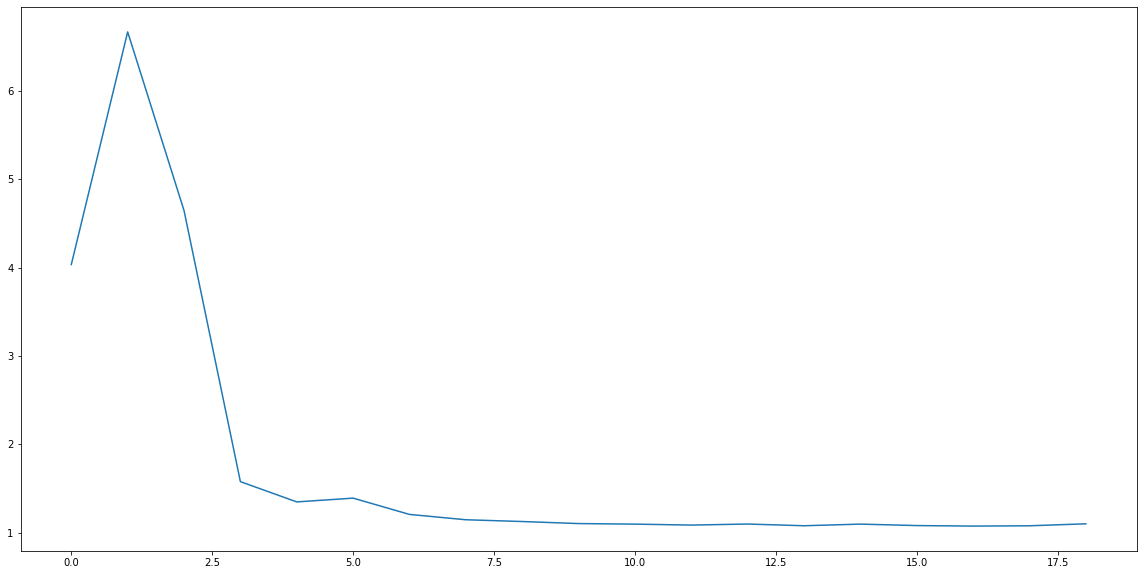

949/1000: 	 loss=8.045284438162113e-07
950/1000: 	 loss=6.703813625062965e-07
951/1000: 	 loss=9.452181712576511e-07
952/1000: 	 loss=7.547202093401633e-07
953/1000: 	 loss=4.1178765890469405e-06
954/1000: 	 loss=4.131824328272423e-06
955/1000: 	 loss=7.405359290748479e-07
956/1000: 	 loss=8.891013267595749e-07
957/1000: 	 loss=7.736224968932329e-07
958/1000: 	 loss=3.170482842092875e-06
959/1000: 	 loss=8.23065765113288e-07
960/1000: 	 loss=7.597041807756523e-07
961/1000: 	 loss=2.7600650103206235e-06
962/1000: 	 loss=4.371298673261259e-06
963/1000: 	 loss=1.6856256840760665e-06
964/1000: 	 loss=1.8647059494995288e-06
965/1000: 	 loss=7.451537386161978e-07
966/1000: 	 loss=1.6468874019197027e-06
967/1000: 	 loss=7.005713012882482e-07
968/1000: 	 loss=3.482454953985303e-06
969/1000: 	 loss=3.550825470019579e-06
970/1000: 	 loss=1.8332436745067615e-06
971/1000: 	 loss=8.275794979332184e-07
972/1000: 	 loss=4.00468664969126e-06
973/1000: 	 loss=5.928438824001184e-06
974/1000: 	 loss=7.86

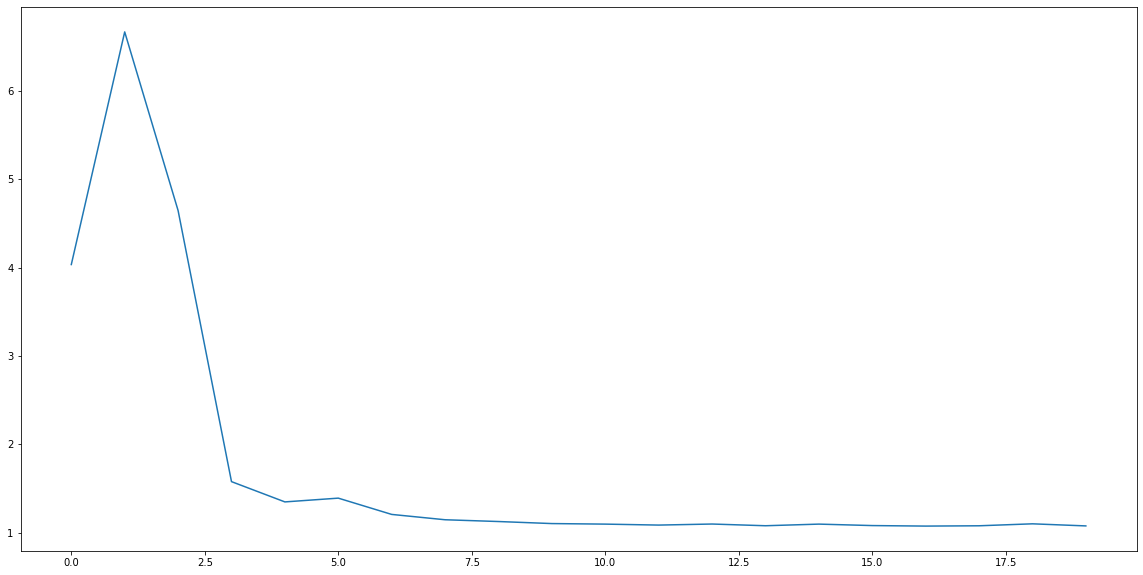

999/1000: 	 loss=4.663620417901256e-06


In [25]:
# Train model

rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=1024, 
        num_units_second_rnn=16,
        num_units_first_dense=0,
        rnn_model_name='lstm',
        num_time_steps=num_time_steps, 
        batch_size=batch_size,
        nan_value=nan_value, 
        input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)
calc_mae_test_fn = model.tf_error(rnn_model, dataset_test, csv_data_set.belt_width, squared=False)
calc_mae_train_fn = model.tf_error(rnn_model, dataset_train, csv_data_set.belt_width, squared=False)

loss_history = []
test_mae_history = []
train_mae_history = []
medians = []
total_num_epochs = 1000

for epoch in range(total_num_epochs):
  if (epoch+1) % 200 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)  
      loss_history.append(loss)
      

  if (epoch+1) % 50 == 0:
    test_mae_history.append(calc_mae_test_fn().numpy())
    train_mae_history.append(calc_mae_train_fn().numpy())
    medians.append(get_median())
    plt.plot(medians)
    plt.show()

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

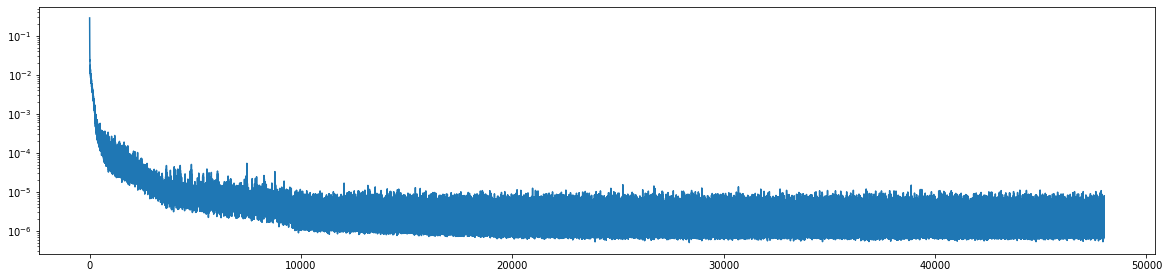

In [26]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')
plt.plot(loss_history)

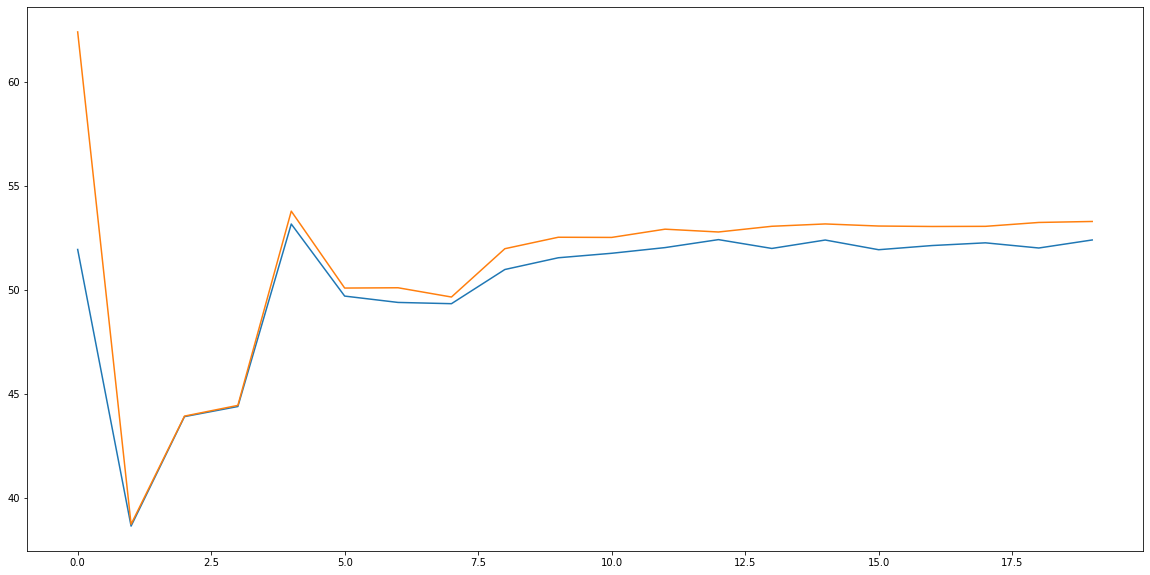

In [27]:
plt.plot(test_mae_history)
plt.plot(train_mae_history)

In [28]:
maes = np.array([])

mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
normalization_factor = csv_data_set.belt_width

for input_batch, target_batch in dataset_test:
    # reset state
    hidden = rnn_model.reset_states()

    batch_predictions = rnn_model(input_batch)

    # Calculate the mask
    mask = K.all(K.equal(target_batch, mask_value), axis=-1)
    mask = 1 - K.cast(mask, tf.float64)
    mask = K.cast(mask, tf.float64)

    target_batch_unnormalized = target_batch * normalization_factor
    pred_batch_unnormalized = batch_predictions * normalization_factor

    batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask
    
    num_time_steps_per_track = tf.reduce_sum(mask, axis=-1)
    
    batch_loss_per_track = tf.reduce_sum(batch_loss, axis=-1) / num_time_steps_per_track

    maes = np.concatenate((maes, batch_loss_per_track.numpy().reshape([-1])))
    
maes.shape

(640,)

In [29]:
np.median(maes)

1.0877150090133245

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8920ade320>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8920adea20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8920ad5f98>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8920adeeb8>],
 'fliers': [],
 'means': []}

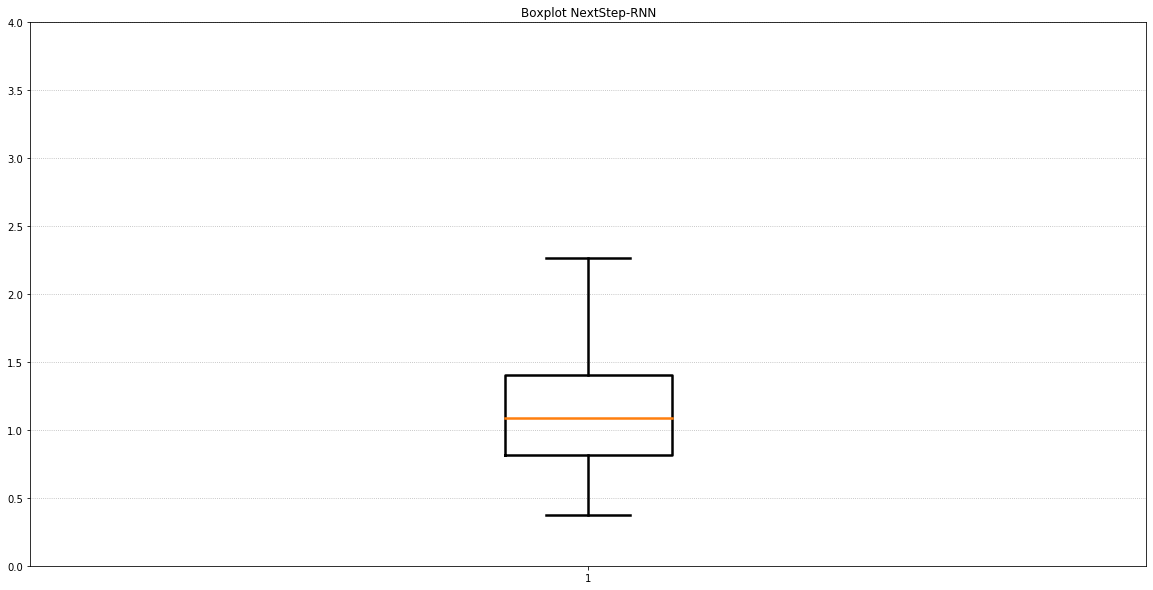

In [30]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([0,4.0])
  
ax1.set_title('Boxplot NextStep-RNN')
prop = dict(linewidth=2.5)
ax1.boxplot(maes, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)